In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context(rc={"figure.figsize": (6,3)})
import scipy.stats as stats
import inspect
import numpy as np
import os

os.chdir(r'C:\Users\Igor\Jupyter_Notebook_Projects\Capstone project')

from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [3]:
# Importing CVD and RF data into a dataframe
df = pd.DataFrame.from_csv('Risk_Factors_CVD.csv', index_col=None)

In [4]:
## Cleaning data:
# Removing repetitive age categories as well as 18-24 group (null values for many factors)
# Removing 'Nutrition' topic (controversial)
# Removing 'Overall' break out and average US LocationID rows
# Selecting year - 2013 data set is most informative
# Removing Washington, DC (outlier, not a good representation)
# Removing 'Non-Hispanic Asian' group (not complete)
a = df.Break_out != '35+'
b = df.Break_out != '75+'
c = df.Break_out != '20-24'
d = df.Break_out != '18-24'
e = df.Break_out != 'Overall'
f = df.Break_out != 'Non-Hispanic Asian'
g = df.LocationAbbr != 'DC'
h = df.Year == 2013
i = df.LocationID != 0.5
j = df.Topic != 'Nutrition'

df1 = df[(a) & (b) & (c) & (d) & (e) & (f) & (g) & (h) & (i) & (j)] # creating a new df1

In [5]:
## Cleaning data:
# Removing repetitive indicators and creating new df2
list = ('post-hospitalization', 'Objective 6', 'Objective 7', 'screening', 'Objective 5', 'Objective 11', 'hypertension medication', 'Objective 8', 'Objective 9')

df2 = df1[~df.Indicator.str.contains('|'.join(list))]

C:\Users\Igor\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [6]:
## Cleaning data:
# Removing rows with null prevalence values and creating new df3
df3 = df2.dropna(subset=['Data_Value'])

In [7]:
# Renaming a few topics
df3 = df3.replace('Acute Myocardial Infarction (Heart Attack)', 'Heart_attack')
df3 = df3.replace('Coronary Heart Disease', 'CHD')
df3 = df3.replace('Physical Inactivity', 'Phys_inact')
df3 = df3.replace('Cholesterol Abnormalities', 'Cholesterol')

In [8]:
# Importing US states socioeconomic data (excluding Washingon, DC) from a csv file to a dataframe
df_us = pd.DataFrame.from_csv('USA_info_excl_DC.csv', index_col=None, encoding='cp1252')
df_us.head()

,LocationID,LocationDesc,GDP_2012,Healthcare_spending_2009,Bachelor_degree,Advanced_degree,Median_household_income_2014,Average_annual_Temp_C,Latitude,Longitude
0,1,Alabama,32615,6271.67,0.235,0.087,41415,17.1,32.806671,-86.791130
1,2,Alaska,61156,9127.65,0.280,0.110,60287,-3.0,61.370716,-152.404419
2,4,Arizona,35195,5433.89,0.275,0.102,46709,15.7,33.729759,-111.431221
3,5,Arkansas,31837,6166.94,0.211,0.075,38758,15.8,34.969704,-92.373123
4,6,California,46029,6237.61,0.314,0.116,67458,15.2,36.116203,-119.681564


In [17]:
# Creating new dataframes for CVD including location ID which is to be used a key for merging
# Grouping by state and calculating mean combined prevalence values for each state
cvd1 = df3[df3.Category == 'Cardiovascular Diseases'][['LocationID', 'LocationDesc', 'Data_Value']].groupby(['LocationID', 'LocationDesc']).mean().reset_index()
cvd1 = cvd1.rename(columns={'Data_Value': 'CVD'})

In [16]:
# Creating a dataframe merging CVD with US states socioeconomic data
df_us_del = df_us.drop('LocationDesc', axis=1)
df4 = pd.merge(cvd1, df_us_del, on='LocationID', how='inner')
# Changing $US values in columns to thousands
df4[['GDP_2012']] = df4.GDP_2012/1000
df4[['Healthcare_spending_2009']] = df4.Healthcare_spending_2009/1000
df4[['Median_household_income_2014']] = df4.Median_household_income_2014/1000
df4.head()

,LocationID,LocationDesc,CVD,GDP_2012,Healthcare_spending_2009,Bachelor_degree,Advanced_degree,Median_household_income_2014,Average_annual_Temp_C,Latitude,Longitude
0,1.0,Alabama,6.305263,32.615,6.27167,0.235,0.087,41.415,17.1,32.806671,-86.791130
1,2.0,Alaska,4.566667,61.156,9.12765,0.280,0.110,60.287,-3.0,61.370716,-152.404419
2,4.0,Arizona,4.826667,35.195,5.43389,0.275,0.102,46.709,15.7,33.729759,-111.431221
3,5.0,Arkansas,6.510000,31.837,6.16694,0.211,0.075,38.758,15.8,34.969704,-92.373123
4,6.0,California,3.400000,46.029,6.23761,0.314,0.116,67.458,15.2,36.116203,-119.681564


## Linear Regression models for CVD

In [23]:
from sklearn import linear_model

In [120]:
# Converting to series and arrays
CVD = df4['CVD']
GDP = df4['GDP_2012']
GDP1 = GDP.reshape(-1,1)
BD = df4['Bachelor_degree']
BD1 = BD.reshape(-1,1)
MHI = df4['Median_household_income_2014']
MHI1 = MHI.reshape(-1,1)
MHI1[:5]

array([[ 41.415],
       [ 60.287],
       [ 46.709],
       [ 38.758],
       [ 67.458]])

**Education - Bachelor degree**

In [53]:
# Initialize model
regression_model = linear_model.LinearRegression()

# Train the model
regression_model.fit(X = BD1, y = CVD)

# Check trained model y-intercept
print(regression_model.intercept_)

# Check trained model coefficients
print(regression_model.coef_)

8.52030691339
[-12.50379807]


In [54]:
regression_model.score(X = BD1, 
                       y = CVD)

0.53159214466180016

In [40]:
#sns.jointplot(df4.CVD, df4.Bachelor_degree, kind='reg', size=4)

In [55]:
train_prediction = regression_model.predict(X = BD1)

# Actual - prediction = residuals
residuals = CVD - train_prediction

residuals.describe()

count    5.000000e+01
mean     7.105427e-16
std      5.791185e-01
min     -1.599990e+00
25%     -3.271848e-01
50%      7.543506e-02
75%      3.750159e-01
max      1.243139e+00
Name: CVD, dtype: float64

In [56]:
SSResiduals = (residuals**2).sum()

SSTotal = ((CVD - CVD.mean())**2).sum()

# R-squared
1 - (SSResiduals/SSTotal)

0.5315921446618004

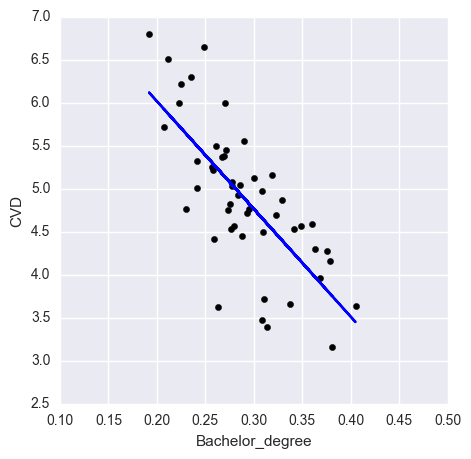

In [57]:
df4.plot(kind="scatter",
           x='Bachelor_degree',
           y='CVD',
           figsize=(5,5),
           color="black",
           xlim = (0.1,0.5))

# Plot regression line
plt.plot(BD1,      # Explanitory variable
         train_prediction,  # Predicted values
         color="blue")

((array([-2.20385432, -1.83293478, -1.61402323, -1.45296849, -1.32267759,
         -1.21163342, -1.113805  , -1.02561527, -0.94475674, -0.86964726,
         -0.79915021, -0.73241807, -0.66879925, -0.6077796 , -0.54894415,
         -0.49195112, -0.43651377, -0.38238727, -0.32935914, -0.27724191,
         -0.2258675 , -0.17508277, -0.12474591, -0.07472335, -0.02488719,
          0.02488719,  0.07472335,  0.12474591,  0.17508277,  0.2258675 ,
          0.27724191,  0.32935914,  0.38238727,  0.43651377,  0.49195112,
          0.54894415,  0.6077796 ,  0.66879925,  0.73241807,  0.79915021,
          0.86964726,  0.94475674,  1.02561527,  1.113805  ,  1.21163342,
          1.32267759,  1.45296849,  1.61402323,  1.83293478,  2.20385432]),
  array([-1.59998984, -1.19411432, -1.18818473, -0.90940349, -0.87972747,
         -0.86182321, -0.63777696, -0.59272348, -0.53447604, -0.49189158,
         -0.45921307, -0.45257679, -0.35121448, -0.25509578, -0.21702071,
         -0.18605824, -0.14783321, -

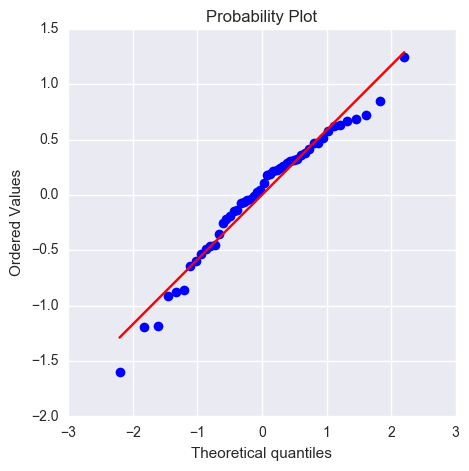

In [58]:
plt.figure(figsize=(5,5))

stats.probplot(residuals, dist="norm", plot=plt)

In [59]:
from sklearn.metrics import mean_squared_error

RMSE = mean_squared_error(train_prediction, CVD)**0.5
RMSE

0.5732980512723187

**Median Household Income**

In [96]:
# Initialize model
regression_model = linear_model.LinearRegression()

# Train the model
regression_model.fit(X = MHI1, y = CVD)

# Check trained model y-intercept
print(regression_model.intercept_)

# Check trained model coefficients
print(regression_model.coef_)

regression_model.score(X = MHI1, 
                       y = CVD)

8.26162411432
[-0.06608899]


0.46873009484767758

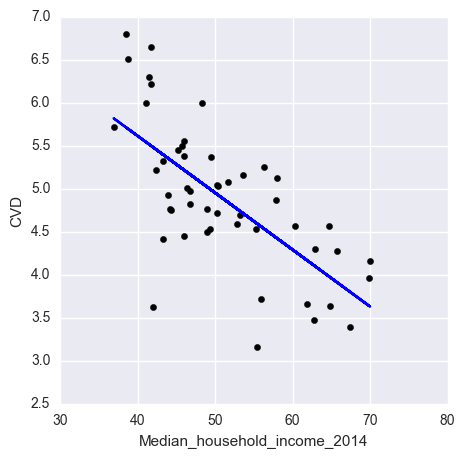

In [99]:
train_prediction = regression_model.predict(X = MHI1)

df4.plot(kind="scatter",
           x='Median_household_income_2014',
           y='CVD',
           figsize=(5,5),
           color="black",
           xlim = (30,80))

# Plot regression line
plt.plot(MHI1,      # Explanitory variable
         train_prediction,  # Predicted values
         color="blue")

In [105]:
RMSE = mean_squared_error(train_prediction, CVD)**0.5
RMSE

0.61055668155246923

**Polynomial Regression for Bachelor Degree**

In [121]:
# Initialize model
poly_model = linear_model.LinearRegression()

# Make a DataFrame of predictor variables
predictors = pd.DataFrame([BD, BD**2]).T     

# Train the model
poly_model.fit(X = predictors, 
               y = CVD)

# Check trained model y-intercept
print("Model intercept")
print(poly_model.intercept_)

# Check trained model coefficients
print("Model Coefficients")
print(poly_model.coef_)

# Check R-squared
poly_model.score(X = predictors, 
                 y = CVD)

Model intercept
12.6172380797
Model Coefficients
[-40.7597506   47.37642921]


0.55856013038748831

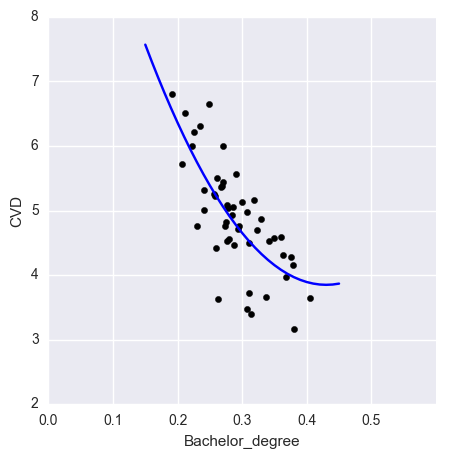

In [122]:
# Plot the curve from 0.1 to 0.5
poly_line_range = np.arange(0.15, 0.45, 0.01)

# Get first and second order predictors from range
poly_predictors = pd.DataFrame([poly_line_range,
                               poly_line_range**2]).T

# Get corresponding y values from the model
y_values = poly_model.predict(X = poly_predictors)

df4.plot(kind="scatter",
           x='Bachelor_degree',
           y='CVD',
           figsize=(5,5),
           color="black",
           xlim = (0,0.6))

# Plot curve line
plt.plot(poly_line_range,   # X-axis range
         y_values,          # Predicted values
         color="blue")

In [123]:
preds = poly_model.predict(X=predictors)

RMSE = mean_squared_error(preds, CVD)**0.5
RMSE

0.55654996287720859

## Multiple Linear Regression for CVD

In [124]:
# Initialize model
multi_reg_model = linear_model.LinearRegression()

# Train the model
multi_reg_model.fit(X = df4.ix[:,['Bachelor_degree', 'Median_household_income_2014', 'GDP_2012']], 
                     y = CVD)

# Check trained model y-intercept
print(multi_reg_model.intercept_)

# Check trained model coefficients
print(multi_reg_model.coef_)

# Check R-squared
multi_reg_model.score(X = df4.ix[:,['Bachelor_degree', 'Median_household_income_2014', 'GDP_2012']], 
                      y = CVD)

8.57006433162
[-8.44786355 -0.03864875  0.01772226]


0.56583336297355991

In [125]:
predictors = pd.DataFrame([BD, MHI, GDP]).T

preds = multi_reg_model.predict(X=predictors)

RMSE = mean_squared_error(preds, CVD)**0.5
RMSE

0.5519460180086958